In [6]:
import pandas as pd
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [7]:
mainpath = "/Users/soldash/Documents/Tesis/python/Datos/Todas/" #ruta de Carga de los datos
filename = "dataframe_concatenado.csv" #Nombre del archivo a cargar

In [8]:
data = pd.read_csv(mainpath+filename, sep=",")
dummy_df = pd.get_dummies(data, columns=['Seizure'])
dummy_df

,ECG,Time,RRI,SDNN,HR,HR_std,NN50,pNN50,HF,LF,Total_power,LF_HF,Seizure_0,Seizure_1,Seizure_2
0,-29.83,2022-07-01 13:25:21.280,680,148.360312,91,1.476621,23,53.488372,3341.061704,5328.681774,28221.219083,1.594907,0,0,1
1,-111.04,2022-07-01 13:25:10.500,664,194.773965,90,1.206969,23,57.500000,1405.554118,1806.423996,7091.854690,1.285204,0,0,1
2,-95.33,2022-07-01 13:25:16.140,832,184.431592,90,1.531681,22,52.380952,2312.004702,4062.403791,20176.263778,1.757091,0,0,1
3,250.32,2022-07-01 13:25:07.140,656,197.497749,89,1.136568,26,65.000000,784.287901,1629.490612,4862.066247,2.077669,0,0,1
4,155.67,2022-07-01 13:25:21.020,680,148.360312,91,1.496815,23,53.488372,3224.521574,5171.380043,27419.724444,1.603767,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55465,21.31,2022-07-02 02:17:01.250,1065,0.000000,53,0.000000,0,0.000000,4952.636478,21698.600327,182813.669515,4.381222,1,0,0
55466,189.18,2022-07-02 02:16:55.150,975,0.000000,53,0.000000,0,0.000000,4752.324507,19376.395447,180128.880924,4.077246,1,0,0
55467,-370.90,2022-07-02 02:16:51.100,965,251.857703,52,0.000000,8,42.105263,4648.755726,18230.284268,163606.994916,3.921541,1,0,0
55468,-9.60,2022-07-02 02:16:18.300,990,391.396444,56,1.295545,7,41.176471,8546.464800,10778.759849,81108.182128,1.261195,1,0,0


Tamaño de muestras preictales :18500


(array([18500.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 18500.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

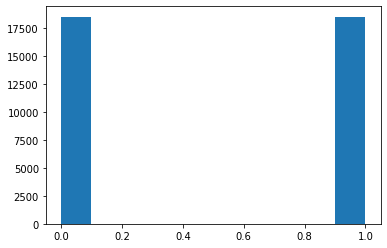

In [9]:
#Igualar muestras
sample_size = dummy_df[dummy_df["Seizure_1"] == 1].shape[0]
print("Tamaño de muestras preictales :"+ str(sample_size))

preictal = dummy_df[dummy_df["Seizure_1"] == 1]
other = dummy_df[dummy_df["Seizure_1"] == 0]

preictal_data = preictal.sample(n= sample_size)
other_data = other.sample(n= sample_size)
    
Sample = pd.concat([preictal_data, other_data], axis = 0)

plt.hist(Sample["Seizure_1"])

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Definiendo los datos
X = Sample[['RRI', 'SDNN', 'HR', 'HR_std', 'NN50', 'pNN50', 'HF', 'LF', 'Total_power', 'LF_HF']]
y = Sample['Seizure_1']

# Dividiendo los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalando los datos (importante para SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Lista de kernels a probar
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

best_accuracy = 0
best_kernel = ""
best_svm = None  # Esta variable almacenará el mejor modelo SVM

for kernel in kernels:
    print(f"Entrenando con kernel: {kernel}")
    svm = SVC(kernel=kernel, gamma='scale')  # gamma='scale' es recomendado para RBF, Poly y Sigmoid
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión con {kernel}: {accuracy}\n")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_kernel = kernel
        best_svm = svm  # Se guarda el mejor modelo SVM en esta variable
        best_y_pred = y_pred
        best_y_test = y_test

print(f"El mejor kernel es: {best_kernel} con una precisión de: {best_accuracy}")


Entrenando con kernel: linear
Precisión con linear: 0.5841891891891892

Entrenando con kernel: poly
Precisión con poly: 0.793918918918919

Entrenando con kernel: rbf
Precisión con rbf: 0.841081081081081

Entrenando con kernel: sigmoid
Precisión con sigmoid: 0.4582432432432432

El mejor kernel es: rbf con una precisión de: 0.841081081081081


In [11]:
# Predice las etiquetas para el conjunto de entrenamiento
y_train_pred = best_svm.predict(X_train)

# Calcula y muestra el accuracy de entrenamiento
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy de Entrenamiento: {train_accuracy}")


Accuracy de Entrenamiento: 0.8411486486486487


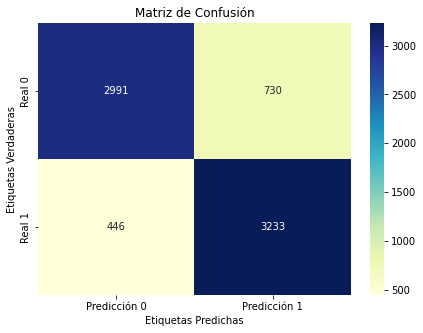

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Crear la matriz de confusión
cm = confusion_matrix(best_y_test, best_y_pred)

# Convertir la matriz de confusión a DataFrame para etiquetar fácilmente los ejes
cm_df = pd.DataFrame(cm, index=['Real 0', 'Real 1'], columns=['Predicción 0', 'Predicción 1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap="YlGnBu", fmt="g")  # fmt="g" para evitar notación científica
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas Verdaderas')
plt.xlabel('Etiquetas Predichas')
plt.show()